# Tic-Tac-Toe

In [1]:
from tkinter import *
import math
from tkinter.font import Font
import sys
import copy
import numpy as np
import _pickle as pickle
from random import shuffle
from matplotlib import pyplot as plt

Za implementaciju bota smo iskoristili Q-learning algoritam sa epsilon-pohlepnom politikom.

Sama Q-tabela implementirana je kroz rečnik. Ključ u rečniku je kodirana vrednost stanja, a vrednost je lista uređenih parova (potez, nagrada).

Кljuč se dobija kada se napravi niska, u kojoj karakter '1' obeležava pozicije na kojima se nalazi 'X', '-1' za 'O', a '9' predstavlja prazno polje. Na kraju se dodaje 'X' ili 'O', u zavisnosti od toga koji igrač je na potezu. 

Primer ključa biće prikazan u primeru kasnije.

### Player class

In [2]:
class Player:
    def __init__(self, mark):
        self.mark = mark
        self.opponentMark()

    def opponentMark(self):
        if self.mark == 'X':
            self.opponent = 'O'
        elif self.mark == 'O':
            self.opponent = 'X'
        else:
            sys.exit("Player's mark needs to be 'X' or 'O'.")

    def getMark(self):
        return self.mark

    # Convert symbol to number for internal representation.
    def mark2num(self):
        if self.mark == 'X':
            return 1
        else:
            return -1

In [3]:
class HumanPlayer(Player):
    pass

In [4]:
class ComputerPlayer(Player):
    def __init__(self, mark, epsilon, Q_table={}):
        super(ComputerPlayer, self).__init__(mark=mark)
        self.Q = Q_table
        self.epsilon = epsilon

    def getMove(self, board):
        if np.random.uniform() < self.epsilon:
            moves = board.availableMoves()
            if moves:   # Make a random move from available ones.
                return moves[np.random.choice(len(moves))]
        else:
            # Find information about current state.
            stateKey = ComputerPlayer.makeAndAddKey(board, self.mark, self.Q)
            Qs = self.Q[stateKey]
            
            # Find best move for current player.
            if self.mark == 'X':
                return ComputerPlayer.stochasticArgminmax(Qs, max)
            else:
                return ComputerPlayer.stochasticArgminmax(Qs, min)

    @staticmethod
    def makeAndAddKey(board, mark, Q):
        # Make new entry if this state is not visited before or get it.
        defaultQValue = 0.0
        stateKey = board.makeKey(mark)
        if Q.get(stateKey) is None:
            moves = board.availableMoves()
            Q[stateKey] = {move: defaultQValue for move in moves}
        return stateKey

    @staticmethod
    def stochasticArgminmax(Qs, minMax):
        # Return min/max rewarded move, depending on player asking.
        QValue = minMax(Qs.values())
        if sum(value == QValue for value in Qs.values()) > 1:
            # If more options with same reward, we choose random one.
            bestOptions = [move for move in Qs.keys() if Qs[move] == QValue]
            move = bestOptions[np.random.choice(len(bestOptions))]
        else:
            move = minMax(Qs, key=Qs.get)
        return move

### Board class

In [5]:
class Board:
    def __init__(self):
        self.emptyText = '--' # Available button text.
        self.empty = np.nan # Available field content.
        self.boardSize = 3 # 3x3 matrix.
        self.over = False
        self.winner = None
        self.fields = np.empty((self.boardSize, self.boardSize,)) # Internal board representation.
        self.fields.fill(self.empty)

    def makeMove(self, player, x, y):
        # Save move internally.
        self.fields[x, y] = player.mark2num()
        return self

    def availableMoves(self):
        return [(x, y) for x in range(self.boardSize) for y in range(self.boardSize) if np.isnan(self.fields[x, y])]

    def nextBoard(self, move, player):
        # Make next board from current and a player`s move.
        nextBoard = copy.deepcopy(self)
        nextBoard.fields[tuple(move)] = player.mark2num()
        if nextBoard.isWon():
            nextBoard.over = True
            nextBoard.winner = player
        elif nextBoard.isOver():
            nextBoard.over = True
        return nextBoard

    def isOver(self):
        return True if len(self.availableMoves()) == 0 else False

    def isWon(self):
        direction = np.nan

        rows = [self.fields[i, :] for i in range(self.boardSize)]        
        cols = [self.fields[:, j] for j in range(self.boardSize)]
        diag = [self.fields[i, i] for i in range(self.boardSize)]
        cross_diag = [self.fields[2-i, i] for i in range(self.boardSize)]

        if any(np.abs(np.sum(rows, axis=1)) == 3):
            direction = 0
        elif any(np.abs(np.sum(cols, axis=1)) == 3):
            direction = 1
        elif np.abs(np.sum(diag)) == 3:
            direction = 2
        elif np.abs(np.sum(cross_diag)) == 3:
            direction = 3
            
        if not np.isnan(direction):
            return self.winningIndexes(direction)
        else:
            return []
        
    def winningIndexes(self, direction):
        if direction == 0:
            row, = np.where(np.abs(np.sum(self.fields, axis=1)) == 3)[0]
            return [(row, j) for j in range(self.boardSize)]            
        elif direction == 1:
            col, = np.where(np.abs(np.sum(self.fields, axis=0)) == 3)[0]
            return [(i, col) for i in range(self.boardSize)]            
        elif direction == 2:
            return [(i, i) for i in range(self.boardSize)]
        else:
            return [(2-i, i) for i in range(self.boardSize)]

    def makeKey(self, mark):
        # Make state key  from current board.
        fillValue = 9
        filledBoard = copy.deepcopy(self.fields)
        np.place(filledBoard, np.isnan(filledBoard), fillValue)
        return "".join(map(str, map(int, filledBoard.flatten()))) + mark

    def giveReward(self):
        if self.over:
            if self.winner:
                if self.winner.getMark() == 'X':
                    return 10
                elif self.winner.getMark() == 'O':
                    return -10
            else: # If draw.
                return -5
        else: # If not over.
            return 0

### Game class

In [6]:
class MainGameGui:    
    def __init__(self, player1, player2, QLearn=False, alpha=0.8, gamma=0.95, decay_factor=0.999995):
        # GUI construction.
        self.app = Tk()
        self.app.title('Tic-Tac-Toe')
        self.app.resizable(width=False, height=False)
        self.turnLabel = ''
        self.buttons = {}
        
        self.playBoard = Board() # Game board.
        self.player1 = player1 # Players
        self.player2 = player2
        self.current_player = player1
        self.other_player = player2
        
        self.QLearn = QLearn
        self.alpha = alpha
        self.gamma = gamma
        self.decay_factor = decay_factor
        
        self.winDetected = {}
        self.Q = {}

        self.initInterface()
        
    def initInterface(self):
        # Prepare GUI interface.
        self.turnLabel = Label(self.app, text=self.current_player.getMark() + '\'s turn', font=Font(size=12))
        it = np.nditer(self.playBoard.fields, flags=['multi_index'])
        while not it.finished:
            (x, y) = it.multi_index
            functionClick = lambda x=x, y=y: self.makeMove(x, y)
            buttonClick = Button(self.app, text=self.playBoard.emptyText, font=Font(family="Times", size=15, weight='bold'), command=functionClick, width=10, height=5)
            buttonClick.grid(row=x, column=y)
            self.buttons[x, y] = buttonClick
            it.iternext()
        functionStart = lambda: self.start()
        buttonStart = Button(self.app, text='New Game', command=functionStart, width = 15)
    
        # Positioning of the elements in GUI
        buttonStart.grid(row=self.playBoard.boardSize, column=self.playBoard.boardSize-1)
        self.turnLabel.grid(row = self.playBoard.boardSize+30, column = 0)
        
    def learnQ(self, move):
        # Implementation of Q-learning algorithm.
        stateKey = ComputerPlayer.makeAndAddKey(self.playBoard, self.current_player.mark, self.Q)
        nextBoard = self.playBoard.nextBoard(move, self.current_player)
        nextReward = nextBoard.giveReward()
        nextStateKey = ComputerPlayer.makeAndAddKey(nextBoard, self.other_player.mark, self.Q)
        
        if nextBoard.isOver():
            expected = nextReward
        else:
            nextQs = self.Q[nextStateKey]

            if self.current_player.mark == 'X':
                expected = nextReward + (self.gamma * min(nextQs.values()))
            else:
                expected = nextReward + (self.gamma * max(nextQs.values()))
        
        change = self.alpha * (expected - self.Q[stateKey][move])

        self.Q[stateKey][move] += change # Update Q-table.

    def makeMove(self, x, y):
        # Mark the move, switch the players and update game status.
        self.playBoard = self.playBoard.makeMove(self.current_player, x, y)
        (self.current_player, self.other_player) = (self.other_player, self.current_player)

        self.updateStatus()

    def nextMove(self):
        if isinstance(self.current_player, HumanPlayer):
            pass
        else:
            move = self.current_player.getMove(self.playBoard)
            if self.QLearn:
                self.learnQ(move)
            self.makeMove(move[0], move[1])

    def start(self):
        if self.QLearn:
            # Update players' Q-table and epsilon.
            if isinstance(self.player1, ComputerPlayer):
                self.player1.Q = self.Q
                self.player1.epsilon *= self.decay_factor
            if isinstance(self.player2, ComputerPlayer):
                self.player2.Q = self.Q
                self.player2.epsilon *= self.decay_factor
        self.playBoard=Board()
        self.current_player = self.player1
        self.other_player = self.player2

        self.updateStatus()

    def updateStatus(self):
        # Update game status and interface.
        self.turnLabel.configure(text=self.current_player.getMark() + '\'s turn')
        it = np.nditer(self.playBoard.fields, flags=['multi_index'])
        while not it.finished:
            (x, y) = it.multi_index
            if self.playBoard.fields[x, y] == 1:
                text = 'X'
            elif self.playBoard.fields[x, y] == -1:
                text = 'O'
            else:
                text = self.playBoard.emptyText
            self.buttons[x, y]['text'] = text
            self.buttons[x, y]['disabledforeground'] = 'black'
            if text == self.playBoard.emptyText:
                self.buttons[x, y]['state'] = 'normal'
            else:
                self.buttons[x, y]['state'] = 'disabled'
            it.iternext()
        self.winDetected = self.playBoard.isWon()
        if self.winDetected:
            self.playBoard.over = True
            for x, y in self.winDetected:
                self.buttons[x, y]['disabledforeground'] = 'red'

            for x, y in self.buttons:
                self.buttons[x, y]['state'] = 'disabled'
            
            it = np.nditer(self.playBoard.fields, flags=['multi_index'])
            while not it.finished:
                (x, y) = it.multi_index
                it.iternext()
                self.buttons[x, y].update()
            self.playBoard.winner = self.other_player
            self.turnLabel.configure(text=self.other_player.getMark() + ' Won!')
            return
        if self.playBoard.isOver():
            self.playBoard.over = True
            return
        self.nextMove()
        
    def close(self):
        self.app.destroy()

    def mainloop(self):
        self.app.mainloop()

## Execution

#### AI vs AI training

In [7]:
lnum_of_games = [20000, 100000, 200000, 500000]
lepsilon = [0.1, 0.2, 0.3, 0.4]

In [8]:
for num_of_games in lnum_of_games:
    for epsilon in lepsilon:
        filename = 'models/Q_table_dictionary_%s_%s.p' % (num_of_games, epsilon)
        game = MainGameGui(ComputerPlayer('X', epsilon=epsilon), ComputerPlayer('O', epsilon=epsilon), QLearn=True)
        for i in range(0, num_of_games):
            game.start()

        pickle.dump(game.Q, open(filename, 'wb')) # Save model.
        game.close()

#### Tournament

In [10]:
models = []
for num_of_games in lnum_of_games:
    for epsilon in lepsilon:
        filename = 'models/Q_table_dictionary_%s_%s.p' % (num_of_games, epsilon)
        models.append((ComputerPlayer('X', Q_table=pickle.load(open(filename, 'rb')), epsilon=0), (num_of_games, epsilon)))        

In [11]:
shuffle(models)

Za implementaciju turnira korišćena je serijska verzija paralelnog algoritma za pronalaženje maksimuma.

In [12]:
start = 0
step = 1
for iter in range(4):
    print('Round: ' + str(iter + 1))
    for match in range(pow(2, 3-iter)):
        first = start + match*pow(2, iter+1)
        player1 = models[first][0]
        player2 = models[first + step][0]
        
        # set 1
        player1.mark = 'X'
        player2.mark = 'O'
        result = 0.0
        game = MainGameGui(player1, player2)
        for r in range(1000):
            game.start()
            if game.winDetected:
                if game.playBoard.winner.getMark() == 'X':
                    result += 1
                elif game.playBoard.winner.getMark() == 'O':
                    result -= 1
            else:
                result -= 0.5 # Reward O for draw.
        game.close()
        print ('Result after set 1: ' + str(result))
        
        # set 2
        player1.mark = 'O'
        player2.mark = 'X'
        game = MainGameGui(player2, player1)
        for r in range(1000):
            game.start()
            if game.winDetected:
                if game.playBoard.winner.getMark() == 'X':
                    result -= 1
                elif game.playBoard.winner.getMark() == 'O':
                    result += 1
            else:
                result += 0.5 # Reward O for draw.
        game.close()
        print ('Result after set 2: ' + str(result))
        
        # Place winner on higher index.
        if result > 0.0:
            print('Model ' + str(models[first][1][0]) + ', ' + str(models[first][1][1]) + ' have beaten model '  + str(models[first + step][1][0]) + ', ' + str(models[first + step][1][1]) + ' with result ' + str(result) + '.')
            (models[first], models[first + step]) = (models[first + step], models[first])
        else:
            print('Model ' + str(models[first + step][1][0]) + ', ' + str(models[first + step][1][1]) + ' have beaten model '  + str(models[first][1][0]) + ', ' + str(models[first][1][1]) + ' with result ' + str(result) + '.')
    start = start + pow(2, iter)
    step = step * 2
    
best_model = models[len(models)-1][0]
best_model_info = models[len(models)-1][1]

Round: 1
Result after set 1: -500.0
Result after set 2: 76.0
Model 500000, 0.3 have beaten model 100000, 0.1 with result 76.0.
Result after set 1: -500.0
Result after set 2: 0.0
Model 200000, 0.3 have beaten model 500000, 0.2 with result 0.0.
Result after set 1: -500.0
Result after set 2: 61.5
Model 200000, 0.2 have beaten model 20000, 0.2 with result 61.5.
Result after set 1: -572.0
Result after set 2: -56.0
Model 20000, 0.3 have beaten model 20000, 0.1 with result -56.0.
Result after set 1: -501.5
Result after set 2: 1.0
Model 100000, 0.4 have beaten model 100000, 0.3 with result 1.0.
Result after set 1: -500.0
Result after set 2: 0.0
Model 100000, 0.2 have beaten model 200000, 0.1 with result 0.0.
Result after set 1: -500.0
Result after set 2: 0.0
Model 200000, 0.4 have beaten model 500000, 0.4 with result 0.0.
Result after set 1: -502.0
Result after set 2: -2.0
Model 500000, 0.1 have beaten model 20000, 0.4 with result -2.0.
Round: 2
Result after set 1: -500.0
Result after set 2: 0

In [13]:
best_model_info

(200000, 0.4)

#### Review epsilon infulence

In [14]:
num_of_games = best_model_info[0]
opponents = []
results = []
i = 0
for epsilon in lepsilon:
    result = 0.0
    filename = 'models/Q_table_dictionary_%s_%s.p' % (num_of_games, epsilon)
    opponents.append(ComputerPlayer('X', Q_table=pickle.load(open(filename, 'rb')), epsilon = 0))
    
    # Set 1:
    best_model.mark = 'X'
    opponents[i].mark = 'O'
    game = MainGameGui(best_model, opponents[i])
    for r in range(1000):
        game.start()
        if game.winDetected:
            if game.playBoard.winner.getMark() == 'X':
                result += 1
            else:
                result -= 1
        else:
            result -= 0.5
    game.close()
    
    # Set 2:
    best_model.mark = 'O'
    opponents[i].mark = 'X'
    game = MainGameGui(opponents[i], best_model)
    for r in range(1000):
        game.start()
        if game.winDetected:
            if game.playBoard.winner.getMark() == 'O':
                result += 1
            else:
                result -= 1
        else:
            result += 0.5
    game.close()
    
    results.append(result)
    
    i += 1

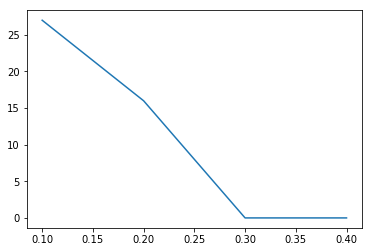

In [15]:
plt.plot(lepsilon, results)

#### Load best model

In [17]:
filename = 'models/Q_table_dictionary_%s_%s.p' % (best_model_info[0], best_model_info[1])
model = ComputerPlayer('X', Q_table=pickle.load(open(filename, 'rb')), epsilon = 0)

#### AI vs Human

In [18]:
MainGameGui(model, HumanPlayer('O')).mainloop()

#### Human vs AI

In [19]:
model.mark = 'O'

In [20]:
MainGameGui(HumanPlayer('X'), model).mainloop()

#### Print Q-table

In [21]:
for key in model.Q:
        print(key, model.Q[key], sep='\t')

999999999X	{(0, 0): -3.317102156445312, (0, 1): -3.317102156445312, (0, 2): -3.317102156445312, (1, 0): -3.317102156445312, (1, 1): -3.317102156445312, (1, 2): -3.317102156445312, (2, 0): -3.317102156445312, (2, 1): -3.317102156445312, (2, 2): -3.317102156445312}
919999999O	{(0, 0): -3.4916864804687497, (0, 2): -3.4916864804687497, (1, 0): 7.737809374999999, (1, 1): -3.4916864804687497, (1, 2): 7.737809374999999, (2, 0): 7.737809374999999, (2, 1): -3.4916864804687497, (2, 2): 7.737809374999999}
919-199999X	{(0, 0): 8.144876246927405, (0, 2): -7.737809374997746, (1, 1): 8.1450625, (1, 2): -3.6754594516801045, (2, 0): -3.675459452979064, (2, 1): -7.7378093749999675, (2, 2): -3.6754594531249936}
919-119999O	{(0, 0): 9.5, (0, 2): 9.5, (1, 2): 9.5, (2, 0): 9.5, (2, 1): 8.57375, (2, 2): 9.5}
-119-119999X	{(0, 2): -9.4986135732224, (1, 2): -9.499999802700595, (2, 0): 8.894025086009343, (2, 1): 10.0, (2, 2): -9.49987061137408}
-111-119999O	{(1, 2): 9.363199844352, (2, 0): -9.999999991808, (2, 

119-1199-19O	{(0, 2): 9.5, (1, 2): 9.5, (2, 0): 9.5, (2, 2): 9.5}
119-1199-1-1X	{(0, 2): 10.0, (1, 2): -9.499999999987098, (2, 0): -4.512499826006485}
119-1191-1-1O	{(0, 2): -4.74999999999995, (1, 2): 9.472597196799999}
119-11-11-1-1X	{(0, 2): 9.99999999967232}
111-11-11-1-1O	{}
19-1919-11-1X	{(0, 1): 10.0, (1, 0): -9.411839993774, (1, 2): 8.952799999998096}
99-191-1199X	{(0, 0): 0.0, (0, 1): -9.058713599999999, (1, 0): -7.62695278592, (2, 1): -9.29024, (2, 2): 9.02499992576285}
99-111-1199O	{(0, 0): -2.17732096, (0, 1): 0.0, (2, 1): 9.457561599999998, (2, 2): -9.999999999997378}
9-1-111-1199X	{(0, 0): 9.9999744, (2, 1): -6.08, (2, 2): -6.08}
191-119-199O	{(0, 1): 9.49999999160995, (1, 2): 9.49999998599168, (2, 1): 9.499999959095705, (2, 2): 9.499999989426392}
191-11-1-199X	{(0, 1): 9.99999999967232, (2, 1): 4.6208, (2, 2): 9.984}
111-11-1-199O	{(2, 1): 0.0, (2, 2): 0.0}
1199-19-199X	{(0, 2): 10.0, (1, 0): -9.499995135750947, (1, 2): -9.484791439350039, (2, 1): -9.499975679750964, (2, 

-1919111-1-1O	{(0, 1): 0.0, (1, 0): 0.0}
111-119-1-19O	{(1, 2): 0.0, (2, 2): 0.0}
11-1999-11-1X	{(1, 0): 0.0, (1, 1): 9.999999999999895, (1, 2): 0.0}
1191999-1-1O	{(0, 2): 0.0, (1, 1): 7.59990272, (1, 2): 0.0, (2, 0): -9.92}
119199-1-1-1X	{(0, 2): 0.0, (1, 1): 0.0, (1, 2): 0.0}
1-199-19911O	{(0, 2): 9.5, (1, 0): 9.5, (1, 2): 9.5, (2, 0): -4.286875}
111-119-19-1O	{(1, 2): 0.0, (2, 1): 0.0}
1-1-1999119O	{(1, 0): 7.5392, (1, 1): 9.107839999999998, (1, 2): 7.295999999999999, (2, 2): 8.813568}
-11-119-1991X	{(1, 1): -3.6100000000000003, (2, 0): -4.508975161343395, (2, 1): 9.024999999999588}
-11-119-1911O	{(1, 1): 9.499999999999893, (2, 0): 9.499999999999934}
999-1-19111O	{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (1, 2): 0.0}
-1991991-11O	{(0, 1): -9.025, (0, 2): -4.286872166318715, (1, 1): -4.286339291248633, (1, 2): -4.285762060679973}
19-1-1991-11X	{(0, 1): -4.5124999999874005, (1, 1): 10.0, (1, 2): -4.51249998087609}
919-111-1-11O	{(0, 0): -9.999998976, (0, 2): 9.423513599988047}
1-19-199-

#### Human vs Human

In [22]:
MainGameGui(HumanPlayer('X'), HumanPlayer('O')).mainloop()

# Literatura

* https://github.com/CrackYSK/Tic-Tac-Toe
* https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py
* http://ml.matf.bg.ac.rs/readings/ml.pdf
* https://docs.python.org/3/library/tk.html
* Materijali sa vežbi